In [23]:
import numpy as np
import pandas as pd

In [24]:
#Import Data
data = pd.read_csv('VIX_data.csv')

In [25]:
#Data Pre-Processing
data.index = pd.to_datetime(data['Date'])

numeric_columns = data.select_dtypes(include=[np.number]).columns
column_means = data[numeric_columns].mean()

data_filled = data.copy()
data_filled[numeric_columns].fillna(column_means)

VIX_data = data_filled['VIX']

if isinstance(VIX_data, pd.Series):
    VIX = VIX_data.to_frame(name='VIX')

data_interim = data_filled.reset_index(drop=True)
data_interim.set_index('Date', inplace=True)

data_interim.index = pd.to_datetime(data_interim.index)

Features = data_interim.drop(['VIX', 'VXN Open', 'VXN High', 'VXN Low', 'VXN Close', 'VXN Adj Close'], axis=1)

In [26]:
from sklearn.preprocessing import StandardScaler

In [27]:
#Scaling the data for the model
scaler = StandardScaler()

scaled_Features = pd.DataFrame(scaler.fit_transform(Features), columns=Features.columns)
scaled_VIX = pd.DataFrame(scaler.fit_transform(VIX), columns=VIX.columns)

In [28]:
import dcor
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import seaborn as sns

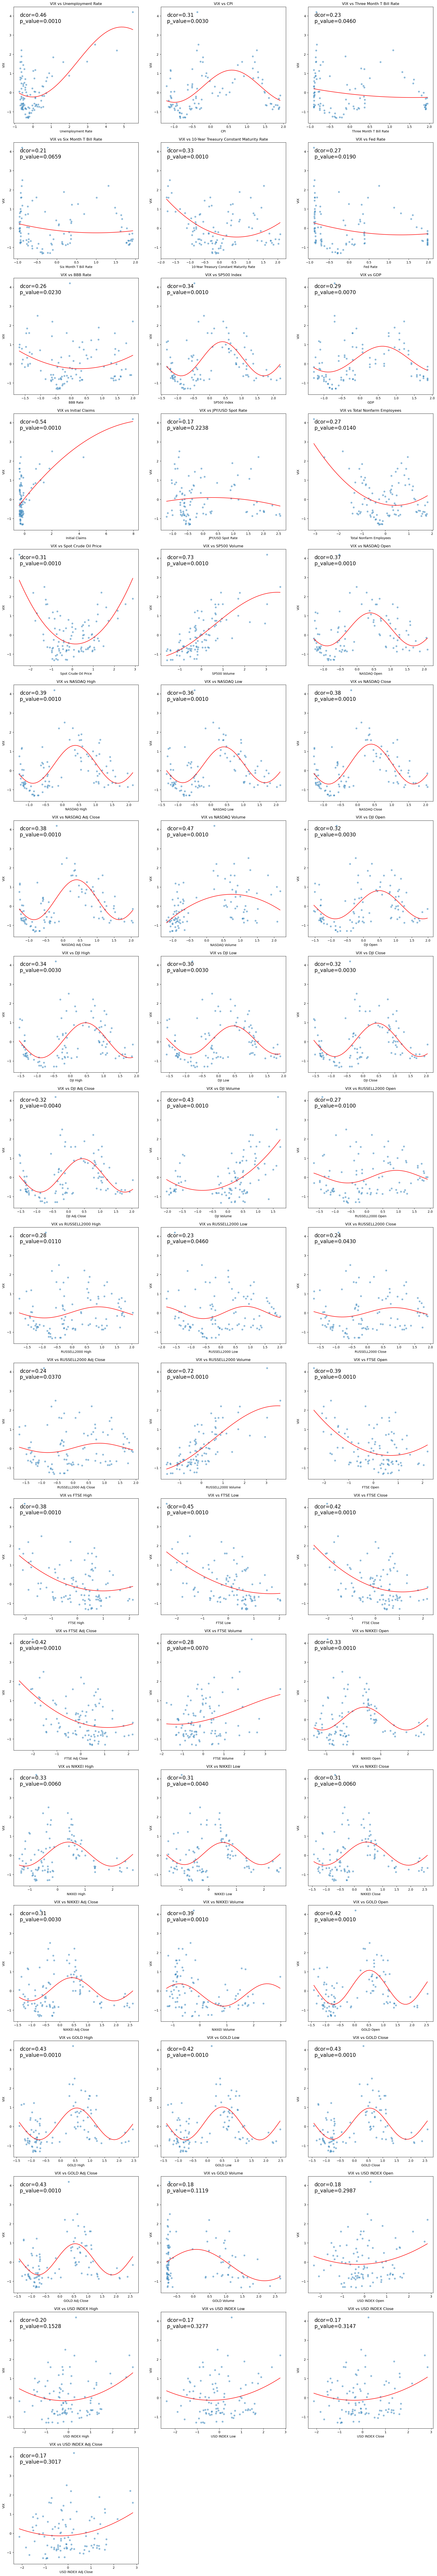

In [29]:
#VIX Vs Feature Plotting and Correlation

def fourier_func(x, a0, a1, b1, w):
    return a0 + a1 * np.cos(w * x) + b1 * np.sin(w * x)

feature_columns = scaled_Features.columns

n_cols = 3
n_rows = (len(feature_columns) + 2) // 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows))
fig.tight_layout(pad=4.0)

dcor_results = {}

for i, feature in enumerate(feature_columns):
    row = i // n_cols
    col = i % n_cols

    ax = axes[row, col] if n_rows > 1 else axes[col]

    sns.scatterplot(x=scaled_Features[feature].squeeze(), y=scaled_VIX.squeeze(), ax=ax, alpha=0.5)

    dc = dcor.distance_correlation(scaled_Features[feature].squeeze(), scaled_VIX.squeeze())

    #Calculate p-value
    p_value = dcor.independence.distance_covariance_test(scaled_Features[feature].squeeze(), 
                                                         scaled_VIX.squeeze(), 
                                                         exponent=1.0,
                                                         num_resamples=1000
                                                         )

    dcor_results[feature] = {'dcor': dc, 'p_value': p_value}

    #Fit Fourier model to the data
    x_data = scaled_Features[feature].values
    y_data = scaled_VIX['VIX'].values

    #Initial guess for parameters [offset, cos amplitude, sin amplitude, frequency]
    initial_guess = [np.mean(y_data), 1, 0, 0.1]

    try:
        params, pcov = curve_fit(fourier_func, x_data, y_data, 
                                 p0=initial_guess, 
                                 maxfev=5000000,
                                 method='trf',
                                 bounds=([-np.inf, -np.inf, -np.inf, 0], [np.inf, np.inf, np.inf, np.inf]))
        x_fit = np.linspace(min(x_data), max(x_data), 50)
        y_fit = fourier_func(x_fit, *params)

        #Plot the fitted sinusoidal curve
        ax.plot(x_fit, y_fit, color='red')
    except Exception as e:
        print(f'Could not fit Fourier model for {feature}: {e}')

    # sns.regplot(x=Features[feature].squeeze(), y=VIX.squeeze(), lowess=True, scatter=False, color='red', ax=ax)

    ax.text(0.05, 0.95, f'dcor={dc:.2f}\np_value={p_value.pvalue:.4f}',
             transform=ax.transAxes,
             fontsize=16, verticalalignment='top'
             )
    
    ax.set_title(f'VIX vs {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('VIX')

#Remove any unused subplots
for i in range(len(feature_columns), n_rows * n_cols):
    row = i // n_cols
    col = i % n_cols
    fig.delaxes(axes[row, col])


plt.show()

dcor_df = pd.DataFrame.from_dict(dcor_results, orient='index')

                                             dcor  \
SP500 Volume                             0.725219   
RUSSELL2000 Volume                       0.724961   
Initial Claims                           0.540863   
NASDAQ Volume                            0.465417   
Unemployment Rate                        0.457294   
FTSE Low                                 0.450251   
GOLD High                                0.430209   
DJI Volume                               0.429454   
GOLD Close                               0.428971   
GOLD Adj Close                           0.428971   
FTSE Close                               0.422108   
FTSE Adj Close                           0.422108   
GOLD Low                                 0.419770   
GOLD Open                                0.416596   
FTSE Open                                0.387205   
NASDAQ High                              0.386293   
NIKKEI Volume                            0.385587   
NASDAQ Adj Close                         0.379

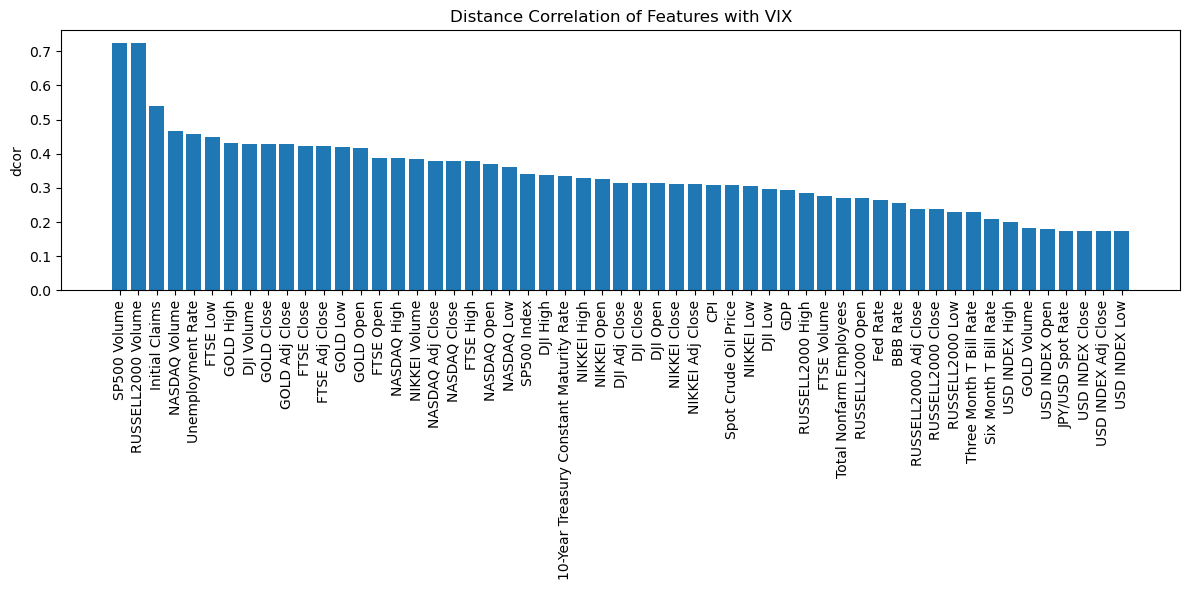

In [30]:
#Plot Distance Correlation / dcor
dcor_df_sorted = dcor_df.sort_values('dcor', ascending=False)
print(dcor_df_sorted)

plt.figure(figsize=(12, 6))
plt.bar(dcor_df_sorted.index, dcor_df_sorted['dcor'])
plt.xticks(rotation=90)
plt.title('Distance Correlation of Features with VIX')
plt.ylabel('dcor')
plt.tight_layout()
plt.show()

CCF-Lasso

In [31]:
from statsmodels.tsa.stattools import ccf

In [32]:
#CCF Analysis
def perform_ccf_analysis(VIX, Features, max_lags, correlation_threshold):
    ccf_results = {}

    for feature in Features.columns:
        ccf_values = ccf(VIX['VIX'], Features[feature], adjusted=True)

        #Consider both positive and negative lags
        ccf_values = np.concatenate([ccf_values[max_lags:0:-1], ccf_values[:max_lags+1]])
        lags = range(-max_lags, max_lags+1)

        #Identify all the lags with correlation above threshold
        significant_lags = [(lag, corr) for lag, corr in zip(lags, ccf_values)
                            if abs(corr) > correlation_threshold]
      
        #Sort by absolute correlation value
        significant_lags.sort(key=lambda x: abs(x[1]), reverse=True)

        ccf_results[feature] = significant_lags
        
    return ccf_results



def create_lagged_features(Features, ccf_results):
    lagged_features = Features.copy()

    for feature, lags in ccf_results.items():
        for lag, _ in lags:
            lagged_feature_name = f'{feature}_lag_{lag}'
            lagged_features[lagged_feature_name] = Features[feature].shift(-lag)

            #Fill NaN values with original feature values
            lagged_features[lagged_feature_name]. fillna(Features[feature], inplace=True)

    return lagged_features


In [33]:
#CCF Analysis 
ccf_results = perform_ccf_analysis(VIX, Features, max_lags=12, correlation_threshold=0.3)

for feature, lags in ccf_results.items():
    print(f'\nFeature: {feature}')
    for lag, corr in lags:
        print(f'Lag: {lag}, Correlation: {corr:.4f}')


Feature: Unemployment Rate
Lag: 0, Correlation: 0.5371
Lag: -1, Correlation: 0.3704
Lag: 1, Correlation: 0.3704
Lag: -2, Correlation: 0.3182
Lag: 2, Correlation: 0.3182

Feature: CPI

Feature: Three Month T Bill Rate

Feature: Six Month T Bill Rate

Feature: 10-Year Treasury Constant Maturity Rate
Lag: -5, Correlation: -0.3339
Lag: 5, Correlation: -0.3339
Lag: -6, Correlation: -0.3326
Lag: 6, Correlation: -0.3326
Lag: -7, Correlation: -0.3249
Lag: 7, Correlation: -0.3249
Lag: -8, Correlation: -0.3090
Lag: 8, Correlation: -0.3090
Lag: -4, Correlation: -0.3058
Lag: 4, Correlation: -0.3058
Lag: -3, Correlation: -0.3002
Lag: 3, Correlation: -0.3002

Feature: Fed Rate

Feature: BBB Rate
Lag: -9, Correlation: -0.4057
Lag: 9, Correlation: -0.4057
Lag: -10, Correlation: -0.3956
Lag: 10, Correlation: -0.3956
Lag: -8, Correlation: -0.3948
Lag: 8, Correlation: -0.3948
Lag: -11, Correlation: -0.3933
Lag: 11, Correlation: -0.3933
Lag: -7, Correlation: -0.3760
Lag: 7, Correlation: -0.3760
Lag: -12,

In [34]:

X = create_lagged_features(Features, ccf_results)
y = VIX['VIX']

/var/folders/p2/s867_82x1zb758ysgxvlj2yw0000gn/T/ipykernel_8692/1543371612.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  lagged_features[lagged_feature_name]. fillna(Features[feature], inplace=True)
/var/folders/p2/s867_82x1zb758ysgxvlj2yw0000gn/T/ipykernel_8692/1543371612.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on whi

In [35]:
from sklearn.linear_model import Lasso

In [ ]:
#Lasso Model
df = pd.concat([y, X], axis=1, join='inner')

#Train and Test Data
train_size = int(len(df)*0.8)
train_data = df[:train_size]
test_data = df[train_size:]

train_target = train_data.iloc[:, 0] #VIX
test_target = test_data.iloc[:, 0]

train_Features = train_data.iloc[:, 1:] #Features
test_Features = test_data.iloc[:, 1:]

alpha = 200 #Learning rate. You can adjust this. 
lasso = Lasso(alpha=alpha, random_state=42)
lasso.fit(train_Features, train_target)

y_pred = lasso.predict(df.iloc[:, 1:])

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.143e+01, tolerance: 2.900e-01
  model = cd_fast.enet_coordinate_descent(


In [44]:
#Identify important features based on Lasso coefficinets
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': abs(lasso.coef_)
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print('\nImportant Features:')
print(feature_importance.head())



Important Features:
             feature  importance
23         DJI Close    0.000270
169  DJI Low_lag_-12    0.000151
145  DJI Open_lag_-8    0.000119
151  DJI Open_lag_-7    0.000074
22           DJI Low    0.000067


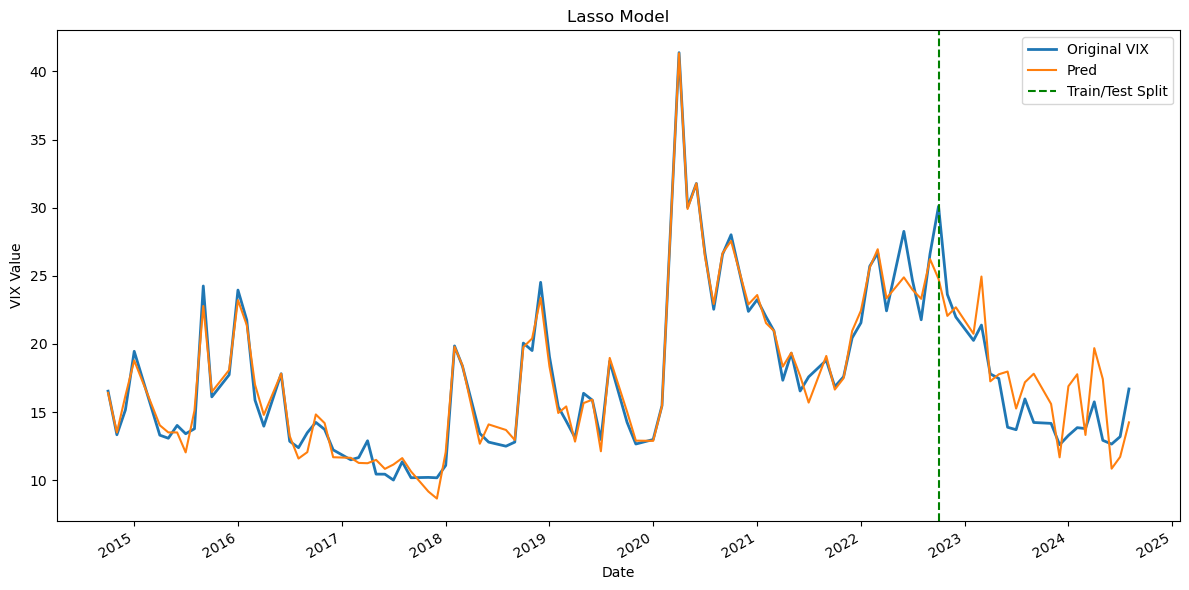

In [45]:
plt.figure(figsize=(12, 6))

plt.plot(df.index, VIX, label='Original VIX', linewidth=2)
plt.plot(df.index, y_pred, label='Pred')

plt.axvline(x=df.index[train_size], color='green', linestyle='--', label='Train/Test Split')

plt.legend(loc='best')
plt.title('Lasso Model')
plt.xlabel('Date')
plt.ylabel('VIX Value')

# Rotate and align the tick labels so they look better
plt.gcf().autofmt_xdate()

# Use tight layout to ensure all elements fit in the figure area
plt.tight_layout()

plt.show()

In [39]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, root_mean_squared_error

In [46]:
def mean_directional_accuracy(actual, predicted):
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    # Calculate the signs of the differences between consecutive values
    actual_diff = np.diff(actual)
    actual_signs = np.sign(actual_diff)
    predicted_diff = np.diff(predicted)
    predicted_signs = np.sign(predicted_diff)
    
    # Count the number of times the signs are the same
    num_correct = np.sum(actual_signs == predicted_signs)
    
    # Calculate the MDA value
    mda = num_correct / (len(actual) - 1)
    
    return mda

In [47]:
mse_lasso = mean_squared_error(VIX, y_pred)
mape_lasso = mean_absolute_percentage_error(VIX, y_pred)
r2_lasso = r2_score(VIX, y_pred)
rmse_lasso = root_mean_squared_error(VIX, y_pred)
da_lasso = mean_directional_accuracy(VIX.iloc[0:, 0], y_pred)

print('\nLasso:')
print(f' MSE : {mse_lasso} \n MAPE: {mape_lasso} \n R2 Score : {r2_lasso} \n RMSE : {rmse_lasso}\n Directon Accuracy : {da_lasso}')


Lasso:
 MSE : 2.0890404900454684 
 MAPE: 0.0619597910458909 
 R2 Score : 0.935418597572941 
 RMSE : 1.4453513379263425
 Directon Accuracy : 0.8235294117647058


SARIMAX-GARCH

In [72]:
#SARIMAX Model
df_timeseries = pd.concat([VIX, Features], axis=1, join='inner')
log_data = np.log1p(df_timeseries)

#Train and Test Data
train_size = int(len(log_data)*0.8)
train_data = log_data[:train_size]
test_data = log_data[train_size:]

train_target = train_data.iloc[:, 0] #VIX
test_target = test_data.iloc[:, 0]

train_Features = train_data.iloc[:, 1:] #Features
test_Features = test_data.iloc[:, 1:]

In [74]:
lags = 50
timeseries = log_data.iloc[:, 0]
exogenous_variables = log_data.iloc[:, 1:]

In [62]:
from pmdarima import auto_arima

In [75]:
#Determine p,d,q using auto_arima
auto_arima_model = auto_arima(timeseries, 
                              exogenous=exogenous_variables,
                              start_p=1, start_q=1, 
                              test='adf',
                              max_p=5, max_q=5,
                              m=12, #VIX data = monthly data with yearly seasonality
                              d=None,
                              seasonal=True,
                              start_P=1, start_Q=1,
                              D=None,
                              trace=True,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=True
                              )

print(auto_arima_model.order)
print(auto_arima_model.seasonal_order)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=-45.569, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-39.711, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-41.242, Time=0.22 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-44.976, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-41.711, Time=0.02 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-47.016, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-46.096, Time=0.10 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=-45.934, Time=1.04 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-46.201, Time=0.37 sec
 ARIMA(1,1,1)(1,0,2)[12] intercept   : AIC=-43.968, Time=1.63 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-42.140, Time=0.09 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=-45.020, Time=0.34 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=-44.945, Time=0.14 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-39.755, Time=0.10 sec
 ARIMA(0,1,2)(0,0,1)[12] intercep

In [76]:
p, d, q =auto_arima_model.order
P, D, Q, m = auto_arima_model.seasonal_order

print(f'p: {p}, d: {d}, q: {q}')
print(f'\nP: {P}, D: {D}, Q: {Q}')

p: 1, d: 1, q: 1

P: 0, D: 0, Q: 1


In [58]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [190]:
#SARIMAX model
P=3
D=0
Q=1 #Can change later
sarimax_model = SARIMAX(train_target,
                        exog=train_Features,
                        order=(p, d, q),
                        seasonal_order=(P, D, Q, m)
                        )

sarimax_results = sarimax_model.fit()

log_sarimax_forecast_in_sample = sarimax_results.predict(start=0, end=len(train_target)-1, exog=train_Features)
log_sarimax_forecast_out_of_sample = sarimax_results.forecast(steps=len(test_target), exog=test_Features)


log_sarimax_forecast = pd.concat([log_sarimax_forecast_in_sample, log_sarimax_forecast_out_of_sample])

sarimax_forecast = np.exp(log_sarimax_forecast)
sarimax_forecast = np.maximum(sarimax_forecast, 0)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           62     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.34161D+00    |proj g|=  3.16406D+00

At iterate    5    f= -1.34634D+00    |proj g|=  3.74842D-01

At iterate   10    f= -1.36490D+00    |proj g|=  4.55132D-01

At iterate   15    f= -1.37589D+00    |proj g|=  2.11154D-01

At iterate   20    f= -1.38552D+00    |proj g|=  1.09915D-01

At iterate   25    f= -1.39627D+00    |proj g|=  2.94189D-01

At iterate   30    f= -1.40498D+00    |proj g|=  5.60992D-01

At iterate   35    f= -1.41017D+00    |proj g|=  5.07875D-01

At iterate   40    f= -1.41554D+00    |proj g|=  3.39277D-01

At iterate   45    f= -1.41795D+00    |proj g|=  2.88455D-01


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -1.42276D+00    |proj g|=  5.67094D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   62     50     57      1     0     0   5.671D-01  -1.423D+00
  F =  -1.4227564620626261     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [114]:
sarimax_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                           SARIMAX Results                                           
=====================================================================================================
Dep. Variable:                                           VIX   No. Observations:                   82
Model:             SARIMAX(1, 1, 1)x(2, 0, [1, 2, 3, 4], 12)   Log Likelihood                 115.687
Date:                                       Thu, 21 Nov 2024   AIC                           -103.374
Time:                                               15:48:48   BIC                             49.871
Sample:                                                    0   HQIC                           -41.890
                                                        - 82                                         
Covariance Type:                                         opg                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Unemployment Rate                          -0.5146      1.257     -0.409      0.682      -2.978       1.949
CPI                                         4.1681     12.995      0.321      0.748     -21.302      29.638
Three Month T Bill Rate                    -0.9042      1.847     -0.490      0.624      -4.524       2.715
Six Month T Bill Rate                       1.4146      1.376      1.028      0.304      -1.283       4.112
10-Year Treasury Constant Maturity Rate     0.1651      1.119      0.148      0.883      -2.028       2.358
Fed Rate                                   -0.1887      0.798     -0.237      0.813      -1.752       1.375
BBB Rate                                   -0.5056      1.938     -0.261      0.794      -4.305       3.294
SP500 Index                                -4.1531      2.442     -1.701      0.089      -8.940       0.634
GDP                                         0.3132      3.027      0.103      0.918      -5.619       6.246
Initial Claims                             -0.0452      0.170     -0.266      0.790      -0.378       0.288
JPY/USD Spot Rate                          -1.4157      2.623     -0.540      0.589      -6.556       3.725
Total Nonfarm Employees                    -7.7203     10.711     -0.721      0.471     -28.713      13.273
Spot Crude Oil Price                        0.0652      0.426      0.153      0.878      -0.769       0.899
SP500 Volume                                2.2766      5.287      0.431      0.667      -8.085      12.639
NASDAQ Open                                -0.1749      2.349     -0.074      0.941      -4.778       4.429
NASDAQ High                                 0.1232      2.642      0.047      0.963      -5.054       5.301
NASDAQ Low                                 -0.9001      1.859     -0.484      0.628      -4.543       2.743
NASDAQ Close                                0.8652      0.844      1.025      0.305      -0.789       2.520
NASDAQ Adj Close                            0.8652      0.844      1.025      0.305      -0.789       2.520
NASDAQ Volume                              -0.0840      0.492     -0.171      0.864      -1.049       0.881
DJI Open                                   -1.7210      1.675     -1.028      0.304      -5.003       1.561
DJI High                                    3.7706      2.792      1.350      0.177      -1.702       9.244
DJI Low                                     2.9678      1.635      1.815      0.070      -0.238       6.173
DJI Close                                  -1.8178      1.308     -1.390      0.165      -4.381       0.745
DJI Adj Close                              -1.8178      1.308     -1.390      0.165      -4.381       0.745
DJI Volume

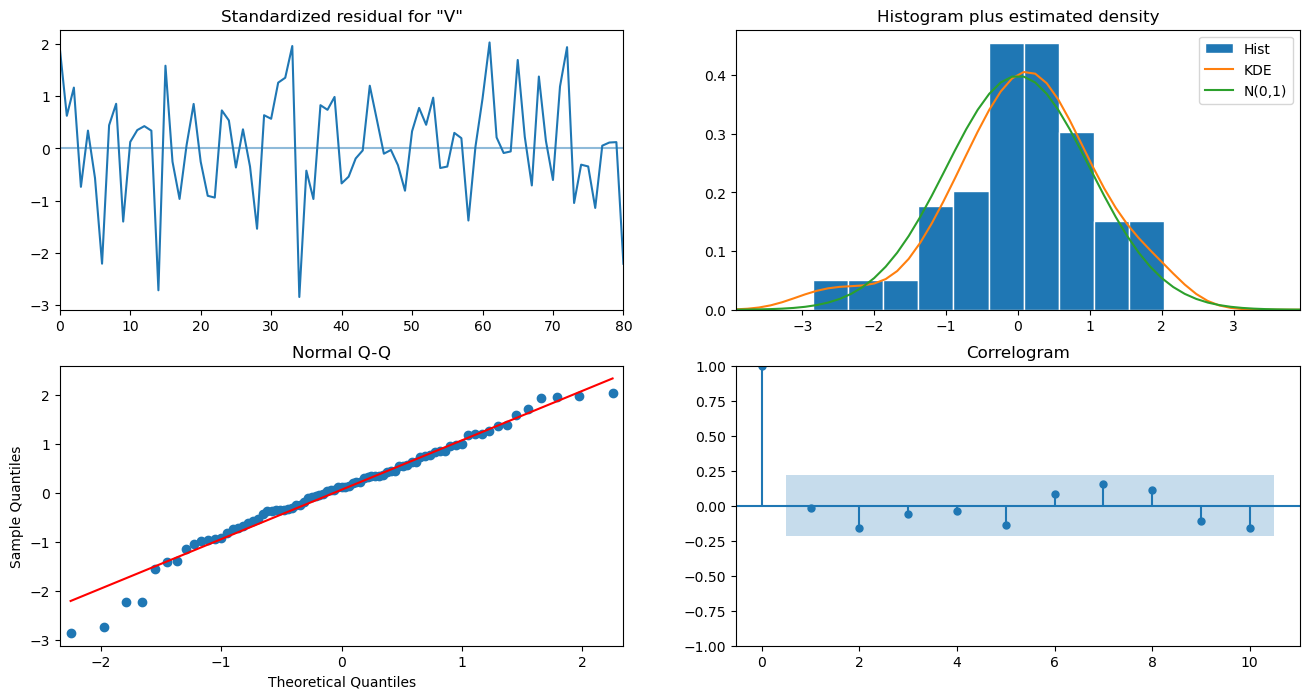

In [115]:
sarimax_results.plot_diagnostics(figsize=(16,8))
plt.show()

In [103]:
from arch import arch_model

In [191]:
#SARIMAX-GARCH model
sarimax_residuals = sarimax_results.resid  

garch_model = arch_model(sarimax_residuals, vol='GARCH', p=2, q=5)
garch_results = garch_model.fit()

garch_forecast = garch_results.forecast(horizon=len(log_sarimax_forecast))
garch_variance = garch_forecast.variance.values[-1, :]

Iteration:      1,   Func. Count:     11,   Neg. LLF: 12854209.6071143
Iteration:      2,   Func. Count:     22,   Neg. LLF: 511185542.214167
Iteration:      3,   Func. Count:     33,   Neg. LLF: 240372.32146958375
Iteration:      4,   Func. Count:     44,   Neg. LLF: 1774816.6578563447
Iteration:      5,   Func. Count:     55,   Neg. LLF: 1914916.2551911834
Iteration:      6,   Func. Count:     66,   Neg. LLF: 150.22736729497942
Iteration:      7,   Func. Count:     76,   Neg. LLF: 8461668.678603915
Iteration:      8,   Func. Count:     87,   Neg. LLF: 9682384.81931188
Iteration:      9,   Func. Count:     98,   Neg. LLF: 208180.6057134642
Iteration:     10,   Func. Count:    109,   Neg. LLF: 119742.37980726651
Iteration:     11,   Func. Count:    120,   Neg. LLF: 168715.1319007614
Iteration:     12,   Func. Count:    131,   Neg. LLF: 36549.377374662305
Iteration:     13,   Func. Count:    142,   Neg. LLF: 75985.65253088201
Iteration:     14,   Func. Count:    153,   Neg. LLF: 29857.9

In [192]:
#Combine SARIMAX mean forecast with GARCH volatility
sarimax_garch_forecast = np.exp(log_sarimax_forecast + np.sqrt(garch_variance) * np.random.standard_normal(len(log_sarimax_forecast)))
sarimax_garch_forecast = np.maximum(sarimax_garch_forecast, 0)

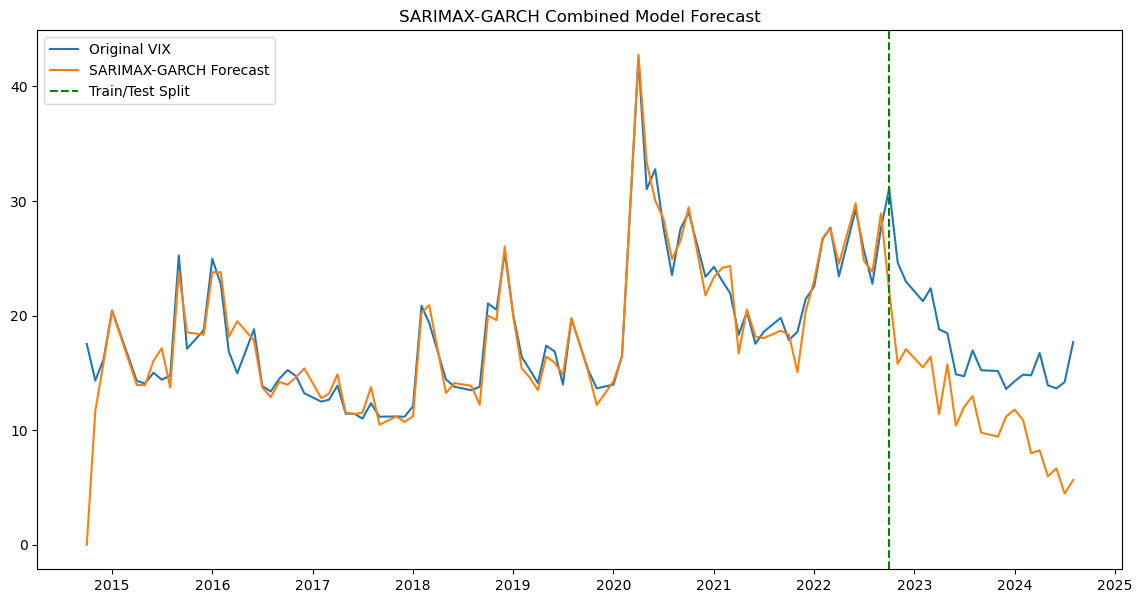

In [193]:
plt.figure(figsize=(14,7))
plt.plot(log_data.index, np.exp(log_data.iloc[:, 0]), label='Original VIX')
plt.plot(log_data.index, sarimax_garch_forecast, label='SARIMAX-GARCH Forecast')

plt.axvline(x=log_data.index[train_size], color='green', linestyle='--', label='Train/Test Split')
plt.legend()
plt.title('SARIMAX-GARCH Combined Model Forecast')
plt.show()

In [194]:
mse_sarimax_garch = mean_squared_error(VIX, sarimax_garch_forecast)
mape_sarimax_garch = mean_absolute_percentage_error(VIX, sarimax_garch_forecast)
r2_sarimax_garch = r2_score(VIX, sarimax_garch_forecast)
rmse_sarimax_garch = root_mean_squared_error(VIX, sarimax_garch_forecast)
da_sarimax_garch = mean_directional_accuracy(VIX.iloc[0:, 0], sarimax_garch_forecast)

print('\nSARIMAX-GARCH:')
print(f' MSE : {mse_sarimax_garch} \n MAPE: {mape_sarimax_garch} \n R2 Score : {r2_sarimax_garch} \n RMSE : {rmse_sarimax_garch} \n Directon Accuracy : {da_sarimax_garch}')


SARIMAX-GARCH:
 MSE : 11.308574619482012 
 MAPE: 0.13210622694241816 
 R2 Score : 0.6504023680453903 
 RMSE : 3.362822418665906 
 Directon Accuracy : 0.7352941176470589
